In [31]:
import torch

device = torch.device('cuda:0')

In [235]:
# IMPORTS
import numpy as np
import os
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
#import pytorch_lightning as pl

# TODO remove
DATA_DIR = 'S:/kaja/ZMO/'
RESULTS_TRAIN_DIR = DATA_DIR+'Results/Results_Training/'
NUM_SEGMENTS = 500
NUM_IMAGES = 369
NUM_FEATURES = 2+10

# LOAD FEATURES
def get_features(features_dir, num_segments):
    X = np.zeros([NUM_IMAGES, num_segments, NUM_FEATURES])
    y = np.zeros([NUM_IMAGES, num_segments])
    num = 0
    i = 0
    for file in os.listdir(features_dir):
        if 'means_b' in file:
            X[num, :, 0] = np.load((features_dir+file), allow_pickle=True)
            i += 1
        elif 'stds_b' in file:
            X[num, :, 1] = np.load((features_dir+file), allow_pickle=True)
            i += 1
        elif 'histograms_b' in file:
            X[num, :, 2:NUM_FEATURES] = np.transpose(np.load((features_dir+file), allow_pickle=True)) # TODO transpose check
            i += 1
        elif 'labels_b' in file:
            y[num, :] = np.squeeze(np.load((features_dir+file)))
            i += 1

        if i == 4:
            num += 1
            i = 0

    X = X.reshape((NUM_IMAGES * num_segments, NUM_FEATURES))
    y = y.reshape((NUM_IMAGES * num_segments,))

    # exclude mixed superpixels
    good = np.where(y != 0.5)[0]
    X = X[good, :]
    y = y[good]
    
    # exclude background
    foreground = np.where(X[:,1] > 1.)[0]
    X = X[foreground, :]
    y = y[foreground]

    # TODO remove
    # random shuffle data
    r = np.array(range(X.shape[0]))
    np.random.shuffle(r)
    X = X[r, :]
    y = y[r]
    
    # select smaller dataset
    size = X.shape[0]
    X = X[:size, :]
    y = y[:size]
    
    # print
    pos = np.where(y == 1)[0]
    neg = np.where(y == 0)[0]
    print(X.shape, y.shape)
    print(len(pos), len(neg))
    
    # calculate weights
    w_pos = (1. / len(pos)) * (size / 2)
    w_neg = (1. / len(neg)) * (size / 2)
    weights = np.empty(size)
    weights[pos] = w_pos
    weights[neg] = w_neg

    return X, y, weights


class Data(Dataset):
    def __init__(self, X, y, weights):
        assert X.shape[0] == y.shape[0] ==  len(weights)
        self.len = X.shape[0]
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))
        self.weights = torch.from_numpy(weights.astype(np.float32))

    def __getitem__(self, index):
        return self.X[index, :], self.y[index], self.weights[index]

    def __len__(self):
        return self.len

# # TODO remove
# X, y = get_features(RESULTS_TRAIN_DIR, NUM_SEGMENTS)
# print(X.dtype)
# print(np.shape(X))

# CLASSIFICATION
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__() #NeuralNetwork, self
        hidden_dim = 30

        self.lin1 = nn.Linear(NUM_FEATURES, hidden_dim)
        self.dropout1 = nn.Dropout(p=0.2)
        self.lin2 = nn.Linear(hidden_dim, hidden_dim)
        self.dropout2 = nn.Dropout(p=0.2)
        self.lin3 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.lin1(x)
        x = torch.nn.functional.relu(x)
        x = self.dropout1(x)
        x = self.lin2(x)
        x = torch.nn.functional.relu(x)
        x = self.dropout2(x)
        x = self.lin3(x)
        x = torch.nn.functional.sigmoid(x)
        return x


In [246]:
model = NeuralNetwork()

X, y, weights = get_features(RESULTS_TRAIN_DIR, NUM_SEGMENTS)
train_data = Data(X, y, weights)
    
num_epochs = 400 #TODO
batch_size = X.shape[0]

# train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

learning_rate = 1e-3

(61178, 12) (61178,)
864 60314


# Train NN on all images (without cross-validation)

In [202]:
loss_values = []
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

X_tens = torch.from_numpy(X.astype(np.float32))
y_tens = torch.from_numpy(y.astype(np.float32))
weights_tens = torch.from_numpy(weights.astype(np.float32))
loss_values = []

# send NN and data to GPU
model.to(device)
X_gpu, y_gpu, weights_gpu = X_tens.to(device), y_tens.to(device), weights_tens.to(device)

for epoch in range(num_epochs):
    print("epoch ", epoch)
    # for X_, y_, weights_ in train_dataloader:
    #     X_gpu_, y_gpu_, weights_gpu_ = X_.to(device), y_.to(device), weights_.to(device)  # send data to GPU
    pred = model(X_gpu).squeeze()
    loss = nn.BCELoss(weight=weights_gpu)(pred, y_gpu)
    loss_values.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # with torch.no_grad():
    #     pred = model(X_gpu).squeeze()
    #     loss = nn.BCELoss(weight=weights_gpu)(pred, y_gpu)
    #     loss_values.append(loss.item())

# send NN back to CPU
model.to('cpu')
print("Training Completed")

epoch  0
epoch  1
epoch  2
epoch  3
epoch  4
epoch  5
epoch  6
epoch  7
epoch  8
epoch  9
epoch  10
epoch  11
epoch  12
epoch  13
epoch  14
epoch  15
epoch  16
epoch  17
epoch  18
epoch  19
epoch  20
epoch  21
epoch  22
epoch  23
epoch  24
epoch  25
epoch  26
epoch  27
epoch  28
epoch  29
epoch  30
epoch  31
epoch  32
epoch  33
epoch  34
epoch  35
epoch  36
epoch  37
epoch  38
epoch  39
epoch  40
epoch  41
epoch  42
epoch  43
epoch  44
epoch  45
epoch  46
epoch  47
epoch  48
epoch  49
epoch  50
epoch  51
epoch  52
epoch  53
epoch  54
epoch  55
epoch  56
epoch  57
epoch  58
epoch  59
epoch  60
epoch  61
epoch  62
epoch  63
epoch  64
epoch  65
epoch  66
epoch  67
epoch  68
epoch  69
epoch  70
epoch  71
epoch  72
epoch  73
epoch  74
epoch  75
epoch  76
epoch  77
epoch  78
epoch  79
epoch  80
epoch  81
epoch  82
epoch  83
epoch  84
epoch  85
epoch  86
epoch  87
epoch  88
epoch  89
epoch  90
epoch  91
epoch  92
epoch  93
epoch  94
epoch  95
epoch  96
epoch  97
epoch  98
epoch  99
epoch  100

In [203]:
# train_data.y = np.array(train_data.y)
model.eval()
with torch.no_grad():
    outputs = model(torch.from_numpy(X.astype(np.float32))).squeeze()
    outputs = np.array(outputs)
    
# count statistics
predictions = np.where(outputs < 0.5, 0, 1)
pos = np.where(y == 1)[0]
neg = np.where(y == 0)[0]
correct_pos = np.sum(predictions[pos] == y[pos])
correct_neg = np.sum(predictions[neg] == y[neg])

total = y.shape[0]
correct = np.sum(predictions == y)
accuracy = correct / total

found_tumors = correct_pos / len(pos)
misslab_nontumors = 1-(correct_neg / len(neg))

print(f"true labels: 1/all: {np.sum(y == 1) / y.shape[0]}")
print(f"positive predictions: {np.sum(predictions != 0)}")
print(f'Accuracy: {accuracy}')
print()
print(f'Found tumors (%): {found_tumors}')
print(f'Misslabeled non-tumors (%): {misslab_nontumors}')
print(f"len(pos): {len(pos)}")
print(f"len(neg): {len(neg)}")

true labels: 1/all: 0.014122723854980548
positive predictions: 23202
Accuracy: 0.6347052862139985

Found tumors (%): 0.9942129629629629
Misslabeled non-tumors (%): 0.37044467287860194
len(pos): 864
len(neg): 60314


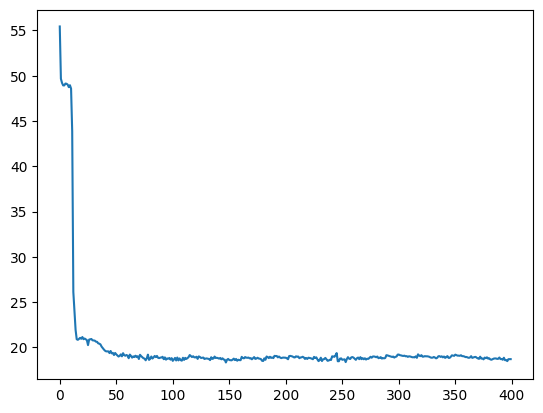

In [204]:
import matplotlib.pyplot as plt
plt.plot(loss_values)
# print(loss_values)

# Display one image and the classification from NN

In [169]:
from preprocessing import *
import matplotlib.pyplot as plt
#DATA_DIR = 'S:/kaja/ZMO/'
DATA_DIR = 'C:/Users/kajin/Documents/_/3/ZMO/sm/archiven/'
RESULTS_TRAIN_DIR = DATA_DIR+'Results/Results_Training/'
TRAIN_DIR = DATA_DIR+'BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'

IMAGE_COUNT = 1
VERSION = 'b'

count = 0
num_segments = 500

X = np.zeros([num_segments, NUM_FEATURES])
y = np.zeros([num_segments])
for (dirpath, dirnames, filenames) in os.walk(TRAIN_DIR):
    for dir in dirnames:

        ### LOAD DATA ###
        img_, mask_ = load_data(dirpath, dir)
        superpixels_ = np.load(RESULTS_TRAIN_DIR+dir+'_superpixels_a.npy', allow_pickle=True)
        means_ = np.load(RESULTS_TRAIN_DIR+dir+'_means_'+VERSION+'.npy', allow_pickle=True)
        stds_ = np.load(RESULTS_TRAIN_DIR+dir+'_stds_'+VERSION+'.npy', allow_pickle=True)
        histograms_ = np.load(RESULTS_TRAIN_DIR+dir+'_histograms_'+VERSION+'.npy', allow_pickle=True)
        labels_ = np.load(RESULTS_TRAIN_DIR+dir+'_labels_'+VERSION+'.npy', allow_pickle=True)
        
        X[:, 0] = means_
        X[:, 1] = stds_
        X[:, 2:NUM_FEATURES] = np.transpose(histograms_)
        y = labels_
        
        count += 1
        print(count)
        if count == IMAGE_COUNT:
            break
    if count == IMAGE_COUNT:
        break
print(X.shape)

1
(500, 12)


In [170]:
with torch.no_grad():
    outputs = model(torch.from_numpy(X.astype(np.float32))).squeeze()
    outputs = np.array(outputs)
    
# count statistics
predictions = np.where(outputs < 0.5, 0, 1)
print(predictions)
pos = np.where(y == 1)[0]
neg = np.where(y == 0)[0]
correct_pos = np.sum(predictions[pos] == y[pos])
correct_neg = np.sum(predictions[neg] == y[neg])

total = y.shape[0]
correct = np.sum(predictions == y)
accuracy = correct / total

found_tumors = correct_pos / len(pos)
misslab_nontumors = 1-(correct_neg / len(neg))

print(f"true labels: 1/all: {np.sum(y == 1) / y.shape[0]}")
print(f"positive predictions: {np.sum(predictions != 0)}")
print(f'Accuracy: {accuracy}')
print()
print(f'Found tumors (%): {found_tumors}')
print(f'Misslabeled non-tumors (%): {misslab_nontumors}')
print(f"len(pos): {len(pos)}")
print(f"len(neg): {len(neg)}")

[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 

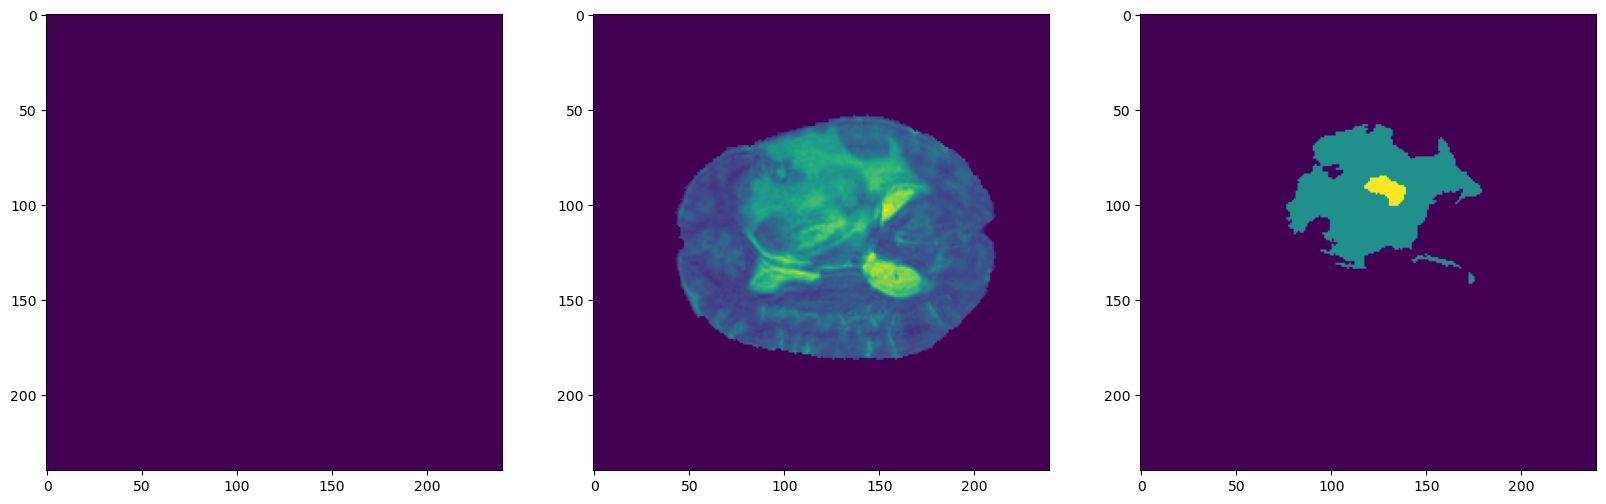

In [171]:
im = np.zeros(np.shape(img_))
idx_tumor = np.where(predictions == 1)
#print(idx_tumor)
#print(len(idx_tumor))

#for i in range(len(predictions)):
    #im[superpixels_ == idx_tumor[i]+1] = 1.
#    if predictions[i] == 1:
#        print(i+1)
#        im[superpixels_ == (i+1)] = 1.
im[superpixels_ == 1] = 1.

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (20, 10))
ax1.imshow(im[:,:,80])
ax2.imshow(img_[:,:,80])
ax3.imshow(mask_[:,:,80])

# Cross validaton, all images


fold 1
Training Completed
validation dataset size: 6118
true labels: 1/all: 0.016345210853220007
positive predictions: 1927
Accuracy: 0.7000653808434129
Found tumors (%): 0.96
Misslabeled non-tumors (%): 0.30425390495181126
len(pos): 100
len(neg): 6018


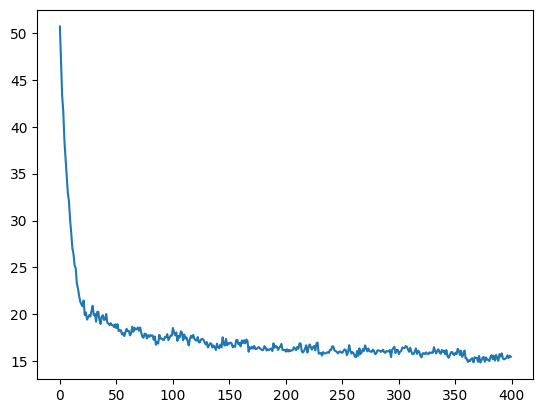


fold 2
Training Completed
validation dataset size: 6118
true labels: 1/all: 0.013239620791108206
positive predictions: 6117
Accuracy: 0.013403072899640406
Found tumors (%): 1.0
Misslabeled non-tumors (%): 0.9998343548119927
len(pos): 81
len(neg): 6037


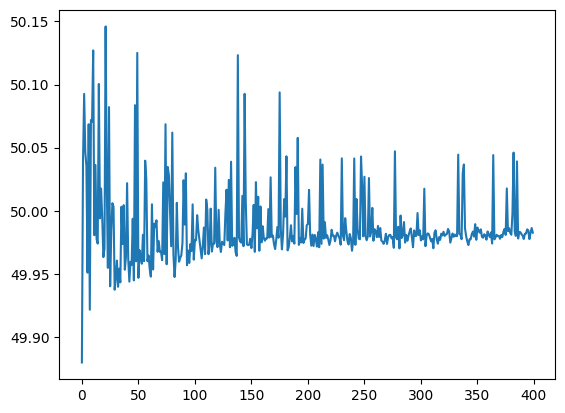


fold 3
Training Completed
validation dataset size: 6118
true labels: 1/all: 0.016181758744687805
positive predictions: 2294
Accuracy: 0.6408957175547565
Found tumors (%): 0.98989898989899
Misslabeled non-tumors (%): 0.36484465858115966
len(pos): 99
len(neg): 6019


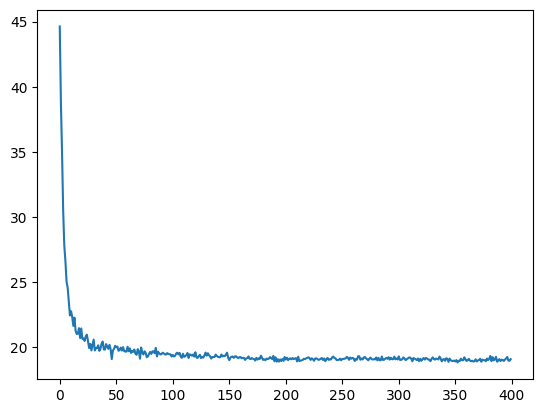


fold 4
Training Completed
validation dataset size: 6118
true labels: 1/all: 0.013239620791108206
positive predictions: 1997
Accuracy: 0.6858450474011115
Found tumors (%): 0.9629629629629629
Misslabeled non-tumors (%): 0.3178731157859864
len(pos): 81
len(neg): 6037


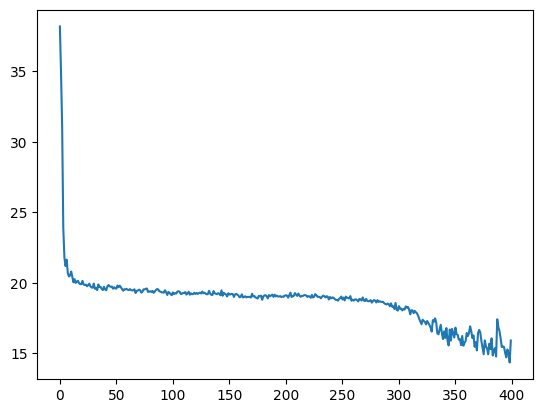


fold 5
Training Completed
validation dataset size: 6118
true labels: 1/all: 0.015527950310559006
positive predictions: 1870
Accuracy: 0.7088917947041516
Found tumors (%): 0.968421052631579
Misslabeled non-tumors (%): 0.29520172671426204
len(pos): 95
len(neg): 6023


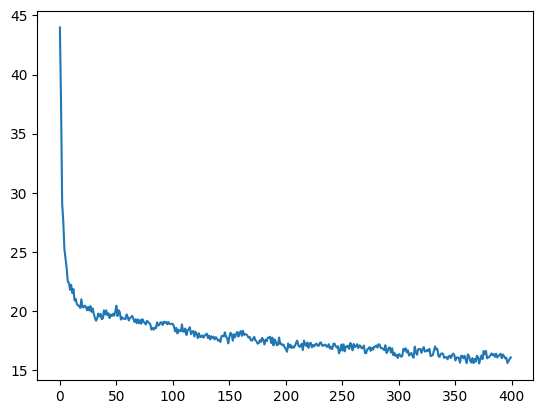


fold 6
Training Completed
validation dataset size: 6118
true labels: 1/all: 0.012585812356979404
positive predictions: 1998
Accuracy: 0.6850277868584504
Found tumors (%): 0.961038961038961
Misslabeled non-tumors (%): 0.3184903161728191
len(pos): 77
len(neg): 6041


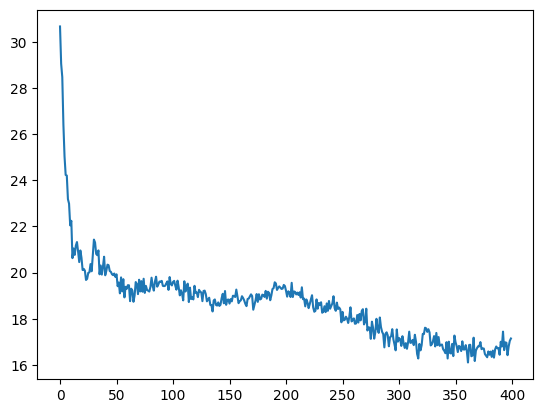

In [247]:
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

folds = 10
TRAIN_RATIO = 0.9

found_tumors = np.zeros(folds,)
misslab_nontumors = np.zeros(folds,)

for fold in range(folds):
    print("\nfold", fold+1)
    indices = np.array(range(X.shape[0]))
    np.random.shuffle(indices)
    cutoff = int(TRAIN_RATIO*len(indices))
    train_idx, val_idx = indices[:cutoff], indices[cutoff:]
    
    X_tens = torch.from_numpy(X[train_idx,:].astype(np.float32))
    y_tens = torch.from_numpy(y[train_idx].astype(np.float32))
    weights_tens = torch.from_numpy(weights[train_idx].astype(np.float32))
    loss_values = []
    
    model = NeuralNetwork()
    loss_values = []
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    # send NN and data to GPU
    model.to(device)
    X_gpu, y_gpu, weights_gpu = X_tens.to(device), y_tens.to(device), weights_tens.to(device)
    
    for epoch in range(num_epochs):
        # print("epoch ", epoch)
        # for X_, y_, weights_ in train_dataloader:
        #     X_gpu_, y_gpu_, weights_gpu_ = X_.to(device), y_.to(device), weights_.to(device)  # send data to GPU
        pred = model(X_gpu).squeeze()
        loss = nn.BCELoss(weight=weights_gpu)(pred, y_gpu)
        loss_values.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # with torch.no_grad():
        #     pred = model(X_gpu).squeeze()
        #     loss = nn.BCELoss(weight=weights_gpu)(pred, y_gpu)
        #     loss_values.append(loss.item())
    
    # send NN back to CPU
    model.to('cpu')
    print("Training Completed")
    
    
    ## VALIDATION
    X_val = X[val_idx,:]
    y_val = y[val_idx]
    
    with torch.no_grad():
        outputs = model(torch.from_numpy(X_val.astype(np.float32))).squeeze()
        outputs = np.array(outputs)
        
    # count statistics
    predictions = np.where(outputs < 0.5, 0, 1)
    pos = np.where(y_val == 1)[0]
    neg = np.where(y_val == 0)[0]
    correct_pos = np.sum(predictions[pos] == y_val[pos])
    correct_neg = np.sum(predictions[neg] == y_val[neg])
    
    total = y_val.shape[0]
    correct = np.sum(predictions == y_val)
    accuracy = correct / total
    
    found_tumors[fold] = correct_pos / len(pos)
    misslab_nontumors[fold] = 1-(correct_neg / len(neg))
    
    print(f"validation dataset size: {len(val_idx)}")
    print(f"true labels: 1/all: {np.sum(y_val == 1) / y_val.shape[0]}")
    print(f"positive predictions: {np.sum(predictions != 0)}")
    print(f'Accuracy: {accuracy}')
    # print()
    print(f'Found tumors (%): {found_tumors[fold]}')
    print(f'Misslabeled non-tumors (%): {misslab_nontumors[fold]}')
    print(f"len(pos): {len(pos)}")
    print(f"len(neg): {len(neg)}")
    
    plt.plot(loss_values)
    plt.show()
    

In [ ]:
print(found_tumors)
print(misslab_nontumors)

avg_found = np.mean(found_tumors)
avg_misslbl = np.mean(misslab_nontumors)

print(avg_found)
print(avg_misslbl)

In [30]:

VERSION = 'b'
np.save(os.path.join(RESULTS_NN, 'NN_outputs_'+str(fold)+'_'+VERSION+NN_SPEC), outputs)

In [32]:
train_data.y = np.array(train_data.y)
with torch.no_grad():
    
    outputs = model(train_data.X).squeeze()
    outputs = np.array(outputs)
    
    # count statistics
    predictions = np.where(outputs < 0.5, 0, 1)
    pos = np.where(y_train == 1)[0]
    neg = np.where(y_train == 0)[0]
    correct_pos = np.sum(predictions[pos] == train_data.y[pos])
    correct_neg = np.sum(predictions[neg] == train_data.y[neg])
    
    total = train_data.y.shape[0]
    correct = np.sum(predictions == train_data.y)
    accuracy = correct / total
    
    found_tumors = correct_pos / len(pos)
    misslab_nontumors = 1-(correct_neg / len(neg))

    print(f"true labels: 1/all: {np.sum(train_data.y == 1) / train_data.y.shape[0]}")
    print(f"positive predictions: {np.sum(predictions != 0)}")
    print(f'Accuracy: {accuracy}')
    print()
    print(f'Found tumors (%): {found_tumors}')
    print(f'Misslabeled non-tumors (%): {misslab_nontumors}')
    print(f"len(pos): {len(pos)}")
    print(f"len(neg): {len(neg)}")

true labels: 1/all: 0.014220623991173405
positive predictions: 28432
Accuracy: 0.41164211429622216

Found tumors (%): 0.23850574712643677
Misslabeled non-tumors (%): 0.5858602607416006
len(pos): 696
len(neg): 48247


# Display one picture - not from NN

In [154]:


from preprocessing import *
import matplotlib.pyplot as plt
TRAIN_DIR = DATA_DIR+'BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'

IMAGE_COUNT = 1
VERSION = 'b'

count = 0
for (dirpath, dirnames, filenames) in os.walk(TRAIN_DIR):
    for dir in dirnames:

        ### LOAD DATA ###
        img_, mask_ = load_data(dirpath, dir)
        superpixels_ = np.load(RESULTS_TRAIN_DIR+dir+'_superpixels_'+VERSION+'.npy', allow_pickle=True)
        tumor_labels = np.load(RESULTS_TRAIN_DIR+dir+'_labels_'+VERSION+'.npy', allow_pickle=True)
        
        count += 1
        print(count)
        if count == IMAGE_COUNT:
            break
    if count == IMAGE_COUNT:
        break


FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/kajin/Documents/_/3/ZMO/sm/archiven/Results/Results_Training/BraTS20_Training_001_superpixels_b.npy'

In [155]:
tumor_pixels = np.zeros((NUM_SEGMENTS, 2))
for (x,y,z), label in np.ndenumerate(superpixels_):
    if mask_[x,y,z] > 0.:
        tumor_pixels[label,0] += 1
    else:
        tumor_pixels[label,1] += 1

low, mid, high = [], [], []

for i in range(NUM_SEGMENTS):
    ratio = tumor_pixels[i,0] / np.sum(tumor_pixels[i,:])
    if ratio > 0.8:
        high.append(i)
 

C:\Users\kajin\AppData\Local\Temp\ipykernel_25228\919076732.py:11: RuntimeWarning: invalid value encountered in scalar divide
  ratio = tumor_pixels[i,0] / np.sum(tumor_pixels[i,:])


In [156]:
print(len(high))

5


[159, 184, 186, 213, 214]
[0. 1. 2. 4.]


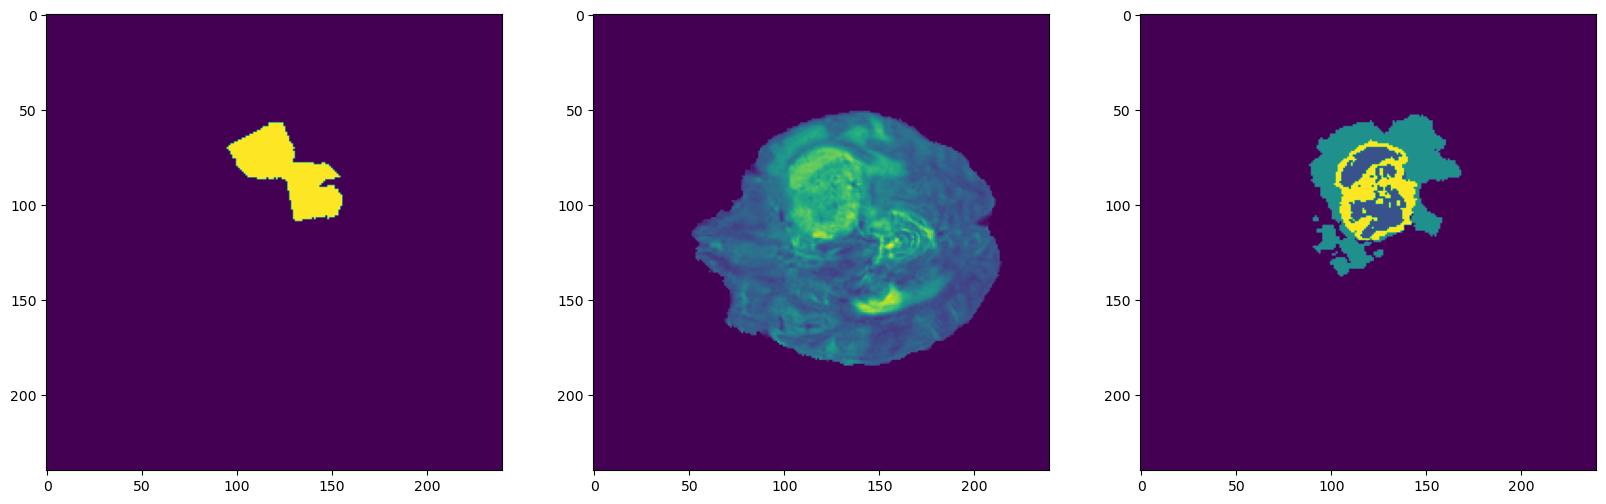

In [158]:
im = np.zeros_like(img_[:,:,:])
im[superpixels_ == (high[0])] = 1.
print(high)

im[superpixels_ == (high[1])] = 1.
#im[superpixels_ == (high[2])] = 1.
#im[superpixels_ == (high[3])] = 1.
#im[superpixels_ == (high[4])] = 1.
#im[superpixels_ == (high[5])] = 1.
#im[superpixels_ == (high[6])] = 1.
#im[superpixels_ == (high[7])] = 1.
#im[superpixels_ == (high[8])] = 1.

print(np.unique(mask_))

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (20, 10))
ax1.imshow(im[:,:,60])
ax2.imshow(img_[:,:,60])
ax3.imshow(mask_[:,:,60])

1
2
3
4
5
6
7
8
9
10


KeyboardInterrupt: 